# Compare the effect of filter on drifter trajectories
- compute MSRe, nMSRe, $C_{\alpha}$, captured physical signal and error parts
- evaluate H1

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
import histlib.diagnosis as diag
from  histlib.diagnosis import global_ms_drifter_sat_year, compute_sum_ms, nMSRe_id, C_x, true_err_x, plot_true_err_cor_part, plot_cor_uncor_part
from histlib.cstes import labels, zarr_dir, matchup_dir, var, c0, c1
from histlib.matchup import _data_var, _stress_var, _aviso_var

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
DL =25*1e3 #meters
DT = 1800.0 #seconds

def put_fig_letter( ax, letter):
    import matplotlib.transforms as mtransforms
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, letter+')', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
    
id_aviso = 'aviso__25__adt__es_cstrio_z15__alti_x'
id_co = 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x'

id_co_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wind':'es_cstrio_z15_alti_wd_x'}
id_aviso_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'aviso_alti_ggx_adt','wind':'es_cstrio_z15_alti_wd_x'}

In [3]:
cutoff = ['0', '25', '15', '05']
ID_CO = [id_co.replace('__25__', f'__{c}__') for c in cutoff]
ID_AVISO = [id_aviso.replace('__25__', f'__{c}__') for c in cutoff]
ID_CO_DIC = []
ID_AV_DIC = []
for c in cutoff : 
    dic = id_co_dic
    dic['acc'] =dic['acc'].replace('x_25', f'x_{c}')
    dic['coriolis'] =dic['coriolis'].replace('x_25', f'x_{c}')
    ID_CO_DIC.append(dic)
    dic = id_aviso_dic
    dic['acc'] =dic['acc'].replace('x_25', f'x_{c}')
    dic['coriolis'] =dic['coriolis'].replace('x_25', f'x_{c}')
    ID_AV_DIC.append(dic)

# Datasets 

In [4]:
dsms = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'ms_{int(DL//1000)}_{DT}_drogued.zarr'))
dsmean = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'mean_{int(DL//1000)}_{DT}_drogued.zarr'))

ds = global_ms_drifter_sat_year(dsmean, dsms, alpha=0.01)[0]

<xarray.DataArray 'nb_coloc' ()>
array(237860)


In [5]:
def true_err_x(ds, id_) :
    dso = xr.Dataset()
    dic = ds['sum_'+id_].attrs
    for x in ['acc', 'coriolis', 'ggrad', 'wind']:
        X =dic[x]
        dso[x] = ds[X]
        dso['exc_'+x] = ds['exc_' + x +'_'+ id_]
        dso['true_'+x] = (ds[X] - ds['sum_'+id_] + ds['exc_' + x +'_'+ id_])/2
        dso['err_'+x] = (ds[X] + ds['sum_'+id_] - ds['exc_' + x +'_'+ id_])/2
    dso['S'] = ds['sum_'+id_]
    return dso
dste = xr.concat([true_err_x(ds, id_co) for id_co in ID_CO], dim=pd.Index(ID_CO, name = 'id_comb'))
dste_av = xr.concat([true_err_x(ds, id_aviso) for id_aviso in ID_AVISO], dim=pd.Index(ID_AVISO, name = 'id_comb'))

In [6]:
dste

<xarray.Dataset>
Dimensions:        (id_comb: 4)
Coordinates:
  * id_comb        (id_comb) object 'co__0__adt_filtered_ocean_tide_internal_...
Data variables: (12/17)
    acc            (id_comb) float64 1.851e-10 9.853e-11 3.237e-11 3.411e-12
    exc_acc        (id_comb) float64 2.34e-10 2.138e-10 1.735e-10 1.462e-10
    true_acc       (id_comb) float64 8.447e-11 7.923e-11 2.401e-11 1.947e-12
    err_acc        (id_comb) float64 1.006e-10 1.93e-11 8.364e-12 1.464e-12
    coriolis       (id_comb) float64 3.877e-10 3.693e-10 3.265e-10 2.88e-10
    exc_coriolis   (id_comb) float64 4.848e-10 4.009e-10 3.705e-10 3.445e-10
    ...             ...
    err_ggrad      (id_comb) float64 7.077e-11 7.114e-11 9.025e-11 9.554e-11
    wind           (id_comb) float64 1.623e-11 1.623e-11 1.623e-11 1.623e-11
    exc_wind       (id_comb) float64 2.618e-10 1.656e-10 1.694e-10 1.538e-10
    true_wind      (id_comb) float64 1.397e-11 1.398e-11 1.39e-11 1.213e-11
    err_wind       (id_comb) float64 2.26e-12 2.252e-12 2.336e-12 4.103e-12
    S              (id_comb) float64 2.501e-10 1.539e-10 1.579e-10 1.457e-10

In [7]:
def plot_cor_uncor_part(ds, ax, title=None):
    """ 
    Parameters
    ----------
    ds : dataset with rms of x, excx and sum (created by )
    id_: identification of the combination
    ax : axis on which to plot

    """
    # ACC X
    ax.bar(1.5, ds['true_acc'],
           color = 'k', width = 0.4, zorder=3, align = 'center')
    ax.bar(1.5, ds['err_acc'], bottom = ds['true_acc'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(1.5, ds['acc']+5e-12, str(np.format_float_scientific(ds['acc'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_acc']/ds['acc']*100,2)
    ax.text(1.5, ds['true_acc']+5e-12, f'{rse.values}%', horizontalalignment='center')

    # CORIOLIS
    ax.bar(2, ds['true_coriolis'],
           color = 'k', width = 0.4, zorder=3, align = 'center')
    ax.bar(2, ds['err_coriolis'], bottom = ds['true_coriolis'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(2, ds['coriolis']+5e-12, str(np.format_float_scientific(ds['coriolis'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_coriolis']/ds['coriolis']*100,2)
    ax.text(2, ds['true_coriolis']+5e-12, f'{rse.values}%', horizontalalignment='center')

    # G GRADIENT SLA
    ax.bar(2.5, ds['true_ggrad'],
           color = 'k', width = 0.4, zorder=3, align = 'center')
    ax.bar(2.5, ds['err_ggrad'], bottom = ds['true_ggrad'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(2.5, ds['ggrad']+5e-12, str(np.format_float_scientific(ds['ggrad'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_ggrad']/ds['ggrad']*100,2)
    ax.text(2.5, ds['true_ggrad']+5e-12, f'{rse.values}%', horizontalalignment='center')

        # WIND
    ax.bar(3, ds['true_wind'],
           color = 'k', width = 0.4, zorder=3, align = 'center')
    ax.bar(3, ds['err_wind'], bottom = ds['true_wind'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(3, ds['wind']+5e-12, str(np.format_float_scientific(ds['wind'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_wind']/ds['wind']*100,2)
    ax.text(3, ds['true_wind']+5e-12, f'{rse.values}%', horizontalalignment='center')

    #ax.set_ylim((0,8e-5))
    ax.grid(axis='y', zorder=0)

    if isinstance(title, int): ax.set_title(ds.id_comb)
    else : ax.set_title(title+'\n')
    
    N=np.arange(1.5,3.5, 0.5) 
    ticks = (r'$d_tu$', r'$-fv$', r'$g \partial_x \eta$', r'$\frac{1}{\rho}\partial_z\tau_x$')
    ax.set_xticks(N, ticks,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


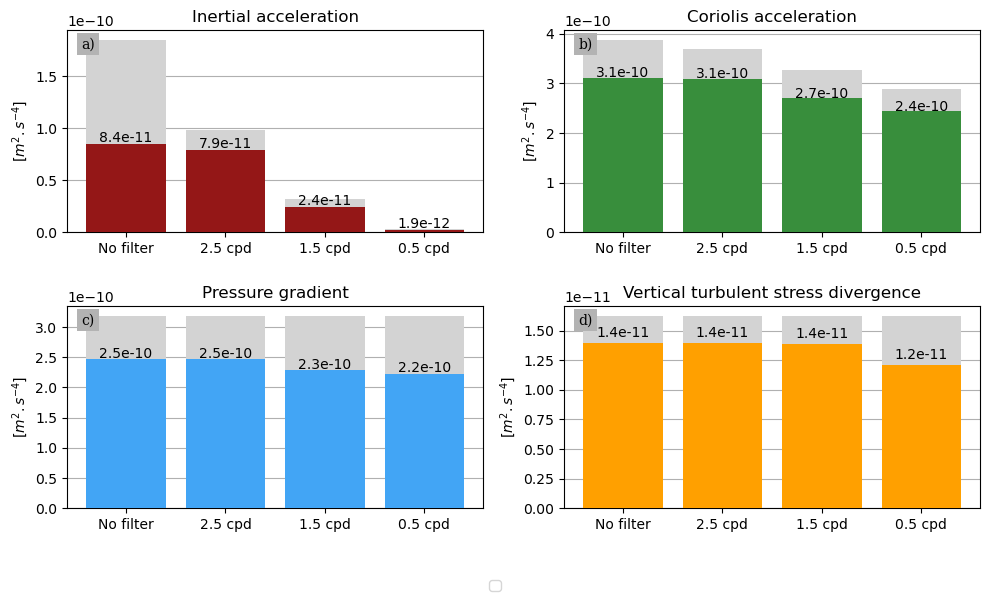

In [8]:
fig, axs = plt.subplots(2,2,figsize=(10,6))
axs =axs.flatten()
xticks = ['No filter', '2.5 cpd', '1.5 cpd', '0.5 cpd']
Title = ['Inertial acceleration','Coriolis acceleration', 'Pressure gradient', 'Vertical turbulent stress divergence']
for i in range(4):
    ds_ = dste.sel(id_comb=ID_CO[i])
    # ACC X
    ax=axs[0]
    ax.bar(i*0.5, ds_['true_acc'],
           color = c0['acc'], width = 0.4, zorder=3, align = 'center')
    ax.bar(i*0.5, ds_['err_acc'], bottom = ds_['true_acc'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(i*0.5, ds_['true_acc']+2e-12, str(np.format_float_scientific(ds_['true_acc'].values,precision = 1)), horizontalalignment='center')
    put_fig_letter(ax, 'a')
    
    # CORIOLIS X
    ax=axs[1]
    ax.bar(i*0.5, ds_['true_coriolis'],
           color = c0['coriolis'], width = 0.4, zorder=3, align = 'center')
    ax.bar(i*0.5, ds_['err_coriolis'], bottom = ds_['true_coriolis'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(i*0.5, ds_['true_coriolis']+2e-12, str(np.format_float_scientific(ds_['true_coriolis'].values,precision = 1)), horizontalalignment='center')
    put_fig_letter(ax, 'b')
    
    # GGRAD X
    ax=axs[2]
    ax.bar(i*0.5, ds_['true_ggrad'],
           color = c0['ggrad'], width = 0.4, zorder=3, align = 'center')
    ax.bar(i*0.5, ds_['err_ggrad'], bottom = ds_['true_ggrad'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(i*0.5, ds_['true_ggrad']+2e-12, str(np.format_float_scientific(ds_['true_ggrad'].values,precision = 1)), horizontalalignment='center')
    put_fig_letter(ax, 'c')
    
    # Wind X
    ax=axs[3]
    ax.bar(i*0.5, ds_['true_wind'],
           color = c0['wind'], width = 0.4, zorder=3, align = 'center')
    ax.bar(i*0.5, ds_['err_wind'], bottom = ds_['true_wind'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(i*0.5, ds_['true_wind']+5e-13, str(np.format_float_scientific(ds_['true_wind'].values,precision = 1)), horizontalalignment='center')
    put_fig_letter(ax, 'd')

i=0    
for ax in axs:
    ax.grid(axis='y', zorder=0)
    ax.set_xticks([0, 0.5, 1, 1.5], xticks)
    ax.set_ylabel(r'$[m^2.s^{-4}]$')
    ax.set_title(Title[i])
    i+=1

fig.legend(ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.08,1,1])#left, bottom, right, top (default is 0,0,1,1)
#ax[0].set_ylabel(r'$[m^2.s^{-4}]$')

fig.savefig('../images_all/filter_comp.png',bbox_inches='tight',   dpi=300)

In [11]:
ID_AVISO

['aviso__0__adt__es_cstrio_z15__alti_x',
 'aviso__25__adt__es_cstrio_z15__alti_x',
 'aviso__15__adt__es_cstrio_z15__alti_x',
 'aviso__05__adt__es_cstrio_z15__alti_x']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


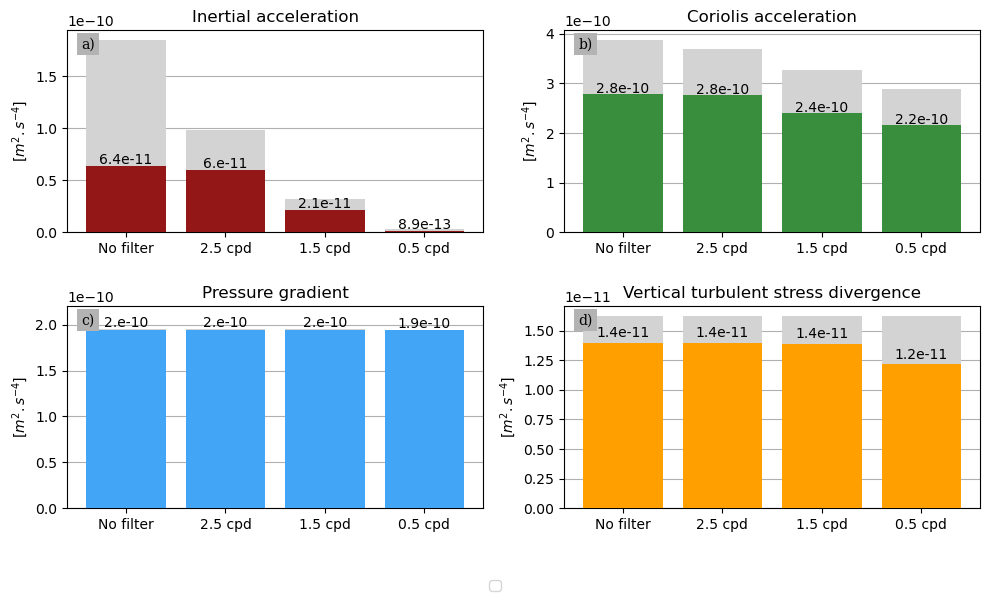

In [15]:
fig, axs = plt.subplots(2,2,figsize=(10,6))
axs =axs.flatten()
xticks = ['No filter', '2.5 cpd', '1.5 cpd', '0.5 cpd']
Title = ['Inertial acceleration','Coriolis acceleration', 'Pressure gradient', 'Vertical turbulent stress divergence']
for i in range(4):
    ds_ = dste_av.sel(id_comb=ID_AVISO[i])
    # ACC X
    ax=axs[0]
    ax.bar(i*0.5, ds_['true_acc'],
           color = c0['acc'], width = 0.4, zorder=3, align = 'center')
    ax.bar(i*0.5, ds_['err_acc'], bottom = ds_['true_acc'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(i*0.5, ds_['true_acc']+2e-12, str(np.format_float_scientific(ds_['true_acc'].values,precision = 1)), horizontalalignment='center')
    put_fig_letter(ax, 'a')
    
    # CORIOLIS X
    ax=axs[1]
    ax.bar(i*0.5, ds_['true_coriolis'],
           color = c0['coriolis'], width = 0.4, zorder=3, align = 'center')
    ax.bar(i*0.5, ds_['err_coriolis'], bottom = ds_['true_coriolis'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(i*0.5, ds_['true_coriolis']+2e-12, str(np.format_float_scientific(ds_['true_coriolis'].values,precision = 1)), horizontalalignment='center')
    put_fig_letter(ax, 'b')
    
    # GGRAD X
    ax=axs[2]
    ax.bar(i*0.5, ds_['true_ggrad'],
           color = c0['ggrad'], width = 0.4, zorder=3, align = 'center')
    ax.bar(i*0.5, ds_['err_ggrad'], bottom = ds_['true_ggrad'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(i*0.5, ds_['true_ggrad']+2e-12, str(np.format_float_scientific(ds_['true_ggrad'].values,precision = 1)), horizontalalignment='center')
    put_fig_letter(ax, 'c')
    
    # Wind X
    ax=axs[3]
    ax.bar(i*0.5, ds_['true_wind'],
           color = c0['wind'], width = 0.4, zorder=3, align = 'center')
    ax.bar(i*0.5, ds_['err_wind'], bottom = ds_['true_wind'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(i*0.5, ds_['true_wind']+5e-13, str(np.format_float_scientific(ds_['true_wind'].values,precision = 1)), horizontalalignment='center')
    put_fig_letter(ax, 'd')

i=0    
for ax in axs:
    ax.grid(axis='y', zorder=0)
    ax.set_xticks([0, 0.5, 1, 1.5], xticks)
    ax.set_ylabel(r'$[m^2.s^{-4}]$')
    ax.set_title(Title[i])
    ax.set_ylim
    i+=1
axs[2].set_ylim(0, 2.2e-10)

fig.legend(ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.08,1,1])#left, bottom, right, top (default is 0,0,1,1)
#ax[0].set_ylabel(r'[m^2/s^4]')
fig.savefig('../images_all/filter_comp_av.png',bbox_inches='tight',   dpi=300)

# Decrease of captured part

In [13]:
(dste.true_acc.isel(id_comb=1)-dste.true_acc.isel(id_comb=0)), (dste.true_acc.isel(id_comb=1)-dste.true_acc.isel(id_comb=0))/dste.true_acc.isel(id_comb=0)*100

(<xarray.DataArray 'true_acc' ()>
 array(-5.23300244e-12),
 <xarray.DataArray 'true_acc' ()>
 array(-6.19533089)
 Coordinates:
     id_comb  <U67 'co__0__adt_filtered_ocean_tide_internal_tide__es_cstrio_z1...)

In [14]:
(dste.true_coriolis.isel(id_comb=1)-dste.true_coriolis.isel(id_comb=0)), (dste.true_coriolis.isel(id_comb=1)-dste.true_coriolis.isel(id_comb=0))/dste.true_coriolis.isel(id_comb=0)*100

(<xarray.DataArray 'true_coriolis' ()>
 array(-2.99814552e-12),
 <xarray.DataArray 'true_coriolis' ()>
 array(-0.96350879)
 Coordinates:
     id_comb  <U67 'co__0__adt_filtered_ocean_tide_internal_tide__es_cstrio_z1...)

# Decrease of error part

In [13]:
(dste.err_acc.isel(id_comb=1)-dste.err_acc.isel(id_comb=0)), (dste.err_acc.isel(id_comb=1)-dste.err_acc.isel(id_comb=0))/dste.err_acc.isel(id_comb=0)*100

(<xarray.DataArray 'err_acc' ()>
 array(-3.57167896e-11),
 <xarray.DataArray 'err_acc' ()>
 array(-66.40910629)
 Coordinates:
     id_comb  <U67 'co__0__adt_filtered_ocean_tide_internal_tide__es_cstrio_z1...)

In [14]:
(dste.err_coriolis.isel(id_comb=1)-dste.err_coriolis.isel(id_comb=0)), (dste.err_coriolis.isel(id_comb=1)-dste.err_coriolis.isel(id_comb=0))/dste.err_coriolis.isel(id_comb=0)*100

(<xarray.DataArray 'err_coriolis' ()>
 array(-1.64417059e-12),
 <xarray.DataArray 'err_coriolis' ()>
 array(-2.53305422)
 Coordinates:
     id_comb  <U67 'co__0__adt_filtered_ocean_tide_internal_tide__es_cstrio_z1...)